In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import itertools
import heapq

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scipy.stats as st
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

In [9]:
# create a dataframe of shape 1024 x 3 + 1
_colnames = ["mean", "median", "max"]
colnames = [f"{col}{i}" for i, col in list(itertools.product(range(1024), _colnames))]
colnames.append("label")
data = pd.DataFrame(columns=colnames)

def prep_datum(datum,i):
  datum = np.array(datum)
  datum = np.concatenate(np.concatenate(datum))
  datum = np.append(datum, i)
  datum = list(datum)
  datum = [v for i, v in enumerate(datum) if i % 4 != 3]
  return datum

# loop through folders, read files, and append them to the database
inputs = os.listdir('/content/drive/MyDrive/training_data')
for i, input in enumerate(inputs):
  try:
    i % 50 == 0 and print(f"{i} / {len(inputs)}")
    if(not input.isdigit()):
      continue
    j = int(i%2==0)
    datum = torch.load(f'/content/drive/MyDrive/training_data/{input}/predictions_{j}.pth')
    datum = prep_datum(datum, j)
    data = data.append(pd.DataFrame([datum],columns=colnames),
              ignore_index = True)
  except:
      breakpoint()

0 / 5016
50 / 5016
100 / 5016
150 / 5016
200 / 5016
250 / 5016
300 / 5016
350 / 5016
400 / 5016
450 / 5016
500 / 5016
550 / 5016
600 / 5016
650 / 5016
700 / 5016
750 / 5016
800 / 5016
850 / 5016
900 / 5016
950 / 5016
1000 / 5016
1050 / 5016
1100 / 5016
1150 / 5016
1200 / 5016
1250 / 5016
1300 / 5016
1350 / 5016
1400 / 5016
1450 / 5016
1500 / 5016
1550 / 5016
1600 / 5016
1650 / 5016
1700 / 5016
1750 / 5016
1800 / 5016
1850 / 5016
1900 / 5016
1950 / 5016
2000 / 5016
2050 / 5016
2100 / 5016
2150 / 5016
2200 / 5016
2250 / 5016
2300 / 5016
2350 / 5016
2400 / 5016
2450 / 5016
2500 / 5016
2550 / 5016
2600 / 5016
2650 / 5016
2700 / 5016
2750 / 5016
2800 / 5016
2850 / 5016
2900 / 5016
2950 / 5016
3000 / 5016
3050 / 5016
3100 / 5016
3150 / 5016
3200 / 5016
3250 / 5016
3300 / 5016
3350 / 5016
3400 / 5016
3450 / 5016
3500 / 5016
3550 / 5016
3600 / 5016
3650 / 5016
3700 / 5016
3750 / 5016
3800 / 5016
3850 / 5016
3900 / 5016
3950 / 5016
4000 / 5016
4050 / 5016
4100 / 5016
4150 / 5016
4200 / 5016
425

In [10]:
# drop medians
for col in colnames:
  col[:3] == "med" and data.drop(columns=col, inplace=True)

In [11]:
# split the data
features = [col for col in colnames[:-1] if col[:3] != "med"]
X = data[features]
y = data.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=16)

In [12]:
# train the model
logreg = LogisticRegression(random_state=16, max_iter=500)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=16)

In [13]:
# evaluate the model oos
y_pred = logreg.predict(X_test)
cnf = metrics.confusion_matrix(y_test, y_pred)
score = logreg.score(X_test, y_test)
print(cnf, score)

[[1213   51]
 [  66 1170]] 0.9532


In [ ]:
# compute t statistic
te0 = cnf[0][1] + cnf[1][1]
te1 = cnf[1][0] + cnf[0][0]
e0 = cnf[0][1] / te0
e1 = cnf[1][0] / te1
e = (e0 + e1)/2
t0 = e0 * (1-e0) / te0
t1 = e1 * (1-e1) / te1
t = (2*e-1)/((t0 + t1)**(1/2))
t

-107.56345278138517

In [ ]:
# run Z test
alpha = .01
thresh = -st.norm.ppf(1-alpha)
t < thresh

True

In [ ]:
# get mean, max coeffs
coef = logreg.coef_[0].tolist()
mean, max = pd.Series(coef[::2]), pd.Series(coef[1::2])

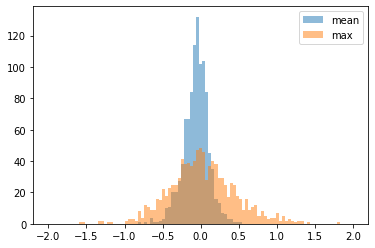

In [ ]:
# show dist of mean and max coeffs
bins = np.linspace(-2, 2, 100)
plt.hist(mean, bins, alpha=0.5, label='mean')
plt.hist(max, bins, alpha=0.5, label='max')
plt.legend(loc='upper right')
plt.show()

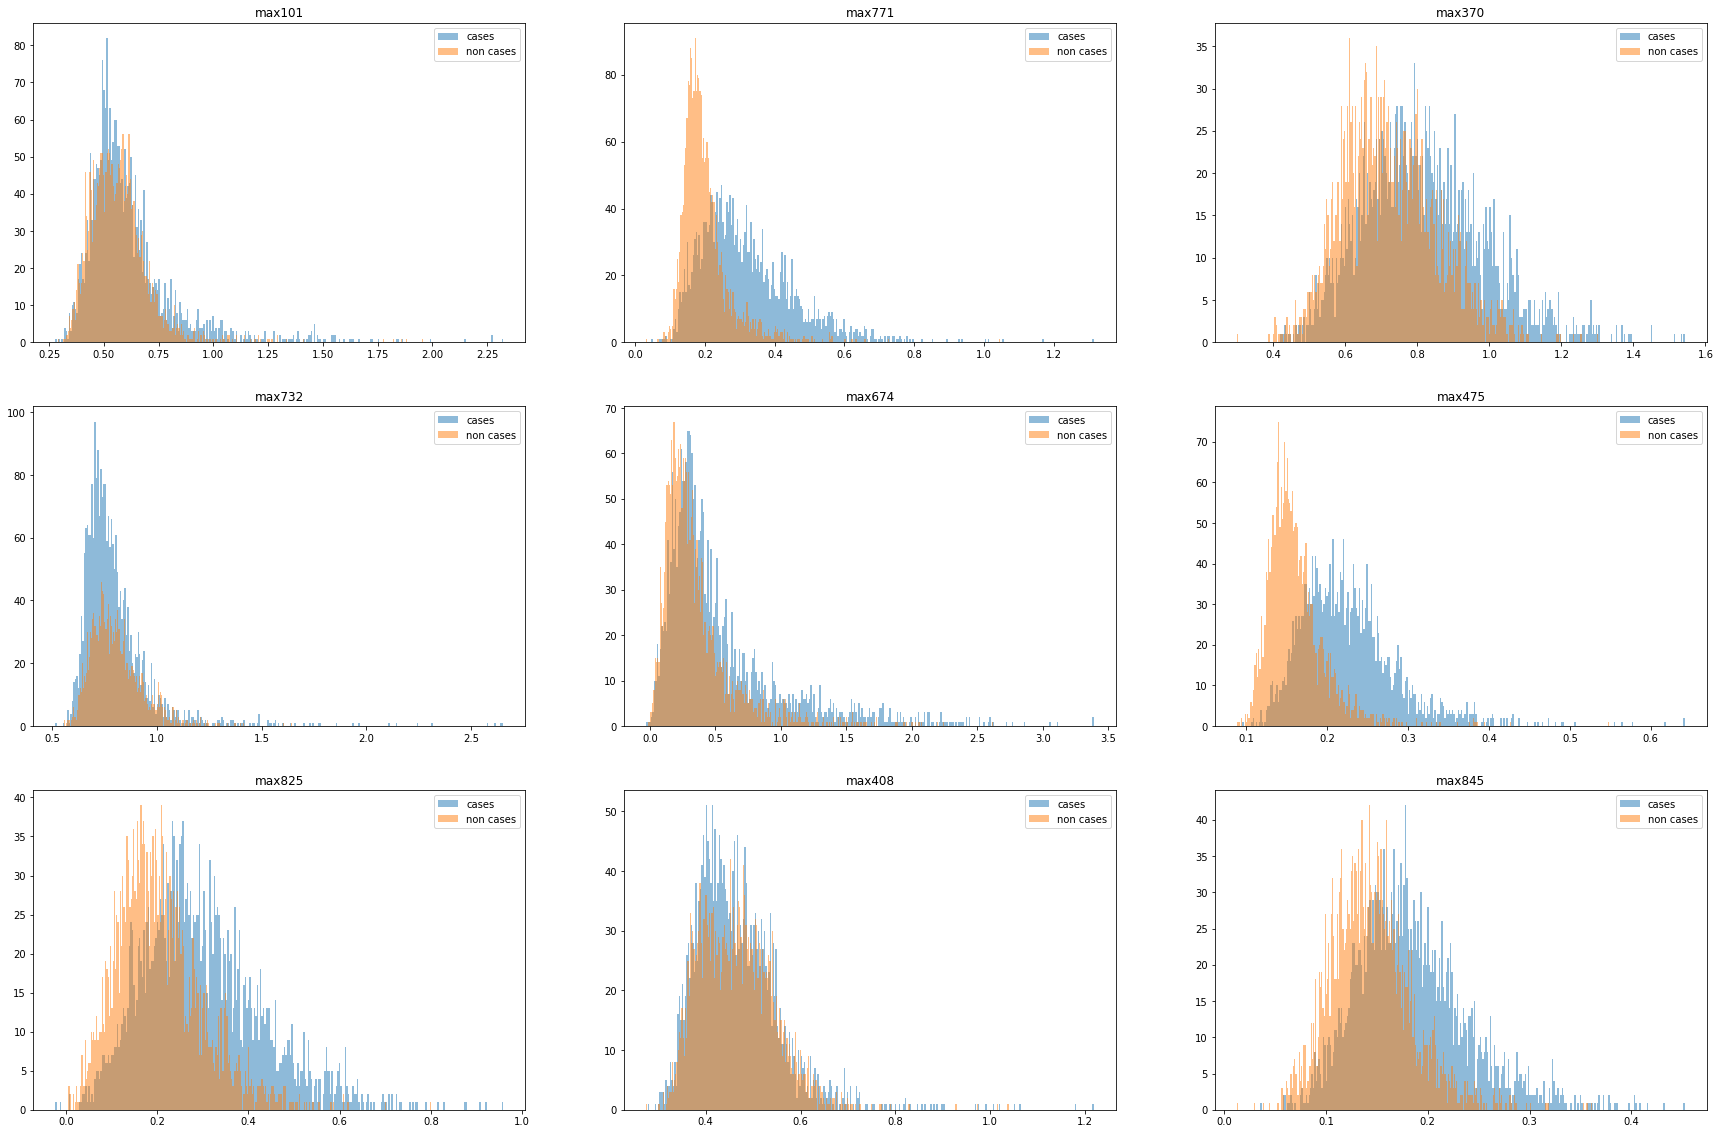

In [ ]:
n=9
coef = [abs(c) for c in coef]
top_n = heapq.nlargest(n, range(len(coef)), coef.__getitem__)
top_n = data.columns[top_n]

fig, axs = plt.subplots(3, 3, figsize=(30,20))
a = axs.ravel()

for idx,ax in enumerate(a):
    col = top_n[idx]
    cases = data[data.label == 1.0][col]
    non_cases = data[data.label == 0.0][col]
    ax.hist(cases, bins=300, alpha=0.5, label='cases')
    ax.hist(non_cases, bins=300, alpha=0.5, label='non cases')
    ax.legend(loc='upper right')
    ax.set_title(col)

2.1465653015784047e-89


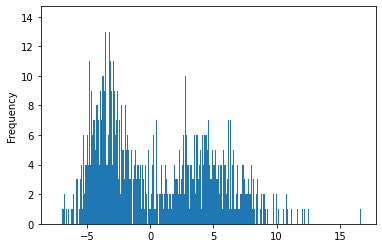

In [15]:
df_out = logreg.decision_function(X_test)
pd.Series(df_out).plot.hist(bins=1500)
stat, p = st.normaltest(df_out)
print(p)

In [ ]:
# run permutation test
scores = []

for i in range(100):
  _y_test = np.random.permutation(y_test)
  _y_pred = logreg.predict(X_test)
  _score = logreg.score(X_test, _y_test)
  scores.append(_score)

In [ ]:
sorted(scores)

[0.4748,
 0.4804,
 0.482,
 0.4844,
 0.4852,
 0.4852,
 0.486,
 0.4868,
 0.4868,
 0.4876,
 0.4884,
 0.4884,
 0.4892,
 0.4892,
 0.4892,
 0.49,
 0.4908,
 0.4916,
 0.4924,
 0.4932,
 0.4932,
 0.494,
 0.4948,
 0.4948,
 0.4948,
 0.4956,
 0.4956,
 0.4956,
 0.4964,
 0.4964,
 0.4964,
 0.4972,
 0.4972,
 0.4972,
 0.4972,
 0.4972,
 0.498,
 0.498,
 0.498,
 0.4988,
 0.4988,
 0.4988,
 0.4988,
 0.4996,
 0.4996,
 0.5004,
 0.5004,
 0.5004,
 0.5004,
 0.5004,
 0.5004,
 0.5012,
 0.5012,
 0.5012,
 0.502,
 0.502,
 0.5028,
 0.5028,
 0.5028,
 0.5028,
 0.5028,
 0.5036,
 0.5036,
 0.5036,
 0.5036,
 0.5036,
 0.5044,
 0.5044,
 0.5044,
 0.5044,
 0.5044,
 0.5044,
 0.5044,
 0.5052,
 0.5052,
 0.5052,
 0.5052,
 0.5052,
 0.506,
 0.506,
 0.506,
 0.506,
 0.5068,
 0.5076,
 0.5076,
 0.5076,
 0.5084,
 0.5084,
 0.5084,
 0.51,
 0.51,
 0.5108,
 0.5116,
 0.5124,
 0.514,
 0.5156,
 0.5172,
 0.5196,
 0.5228,
 0.5284]

In [ ]:
score > sorted(scores)[-1]

True

In [ ]:
scores.append(score)

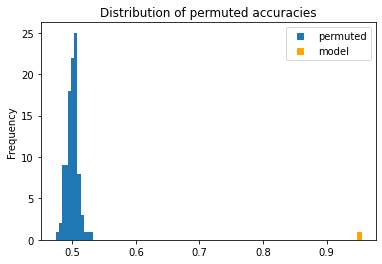

In [ ]:
s = pd.Series(scores)
p = s.plot(kind='hist', bins=100)

bar_value_to_label = .958
min_distance = float("inf")  # initialize min_distance with infinity
index_of_bar_to_label = 0
for i, rectangle in enumerate(p.patches):  # iterate over every bar
    tmp = abs(  # tmp = distance from middle of the bar to bar_value_to_label
        (rectangle.get_x() +
            (rectangle.get_width() * (1 / 2))) - bar_value_to_label)
    if tmp < min_distance:  # we are searching for the bar with x cordinate
                            # closest to bar_value_to_label
        min_distance = tmp
        index_of_bar_to_label = i
p.patches[index_of_bar_to_label].set_color('orange')

plt.title("Distribution of permuted accuracies")

eight = mlines.Line2D([], [], color='#1f77b4', marker='s', ls='', label='permuted')
nine = mlines.Line2D([], [], color='orange', marker='s', ls='', label='model')
# etc etc
plt.legend(handles=[eight, nine])

plt.show()